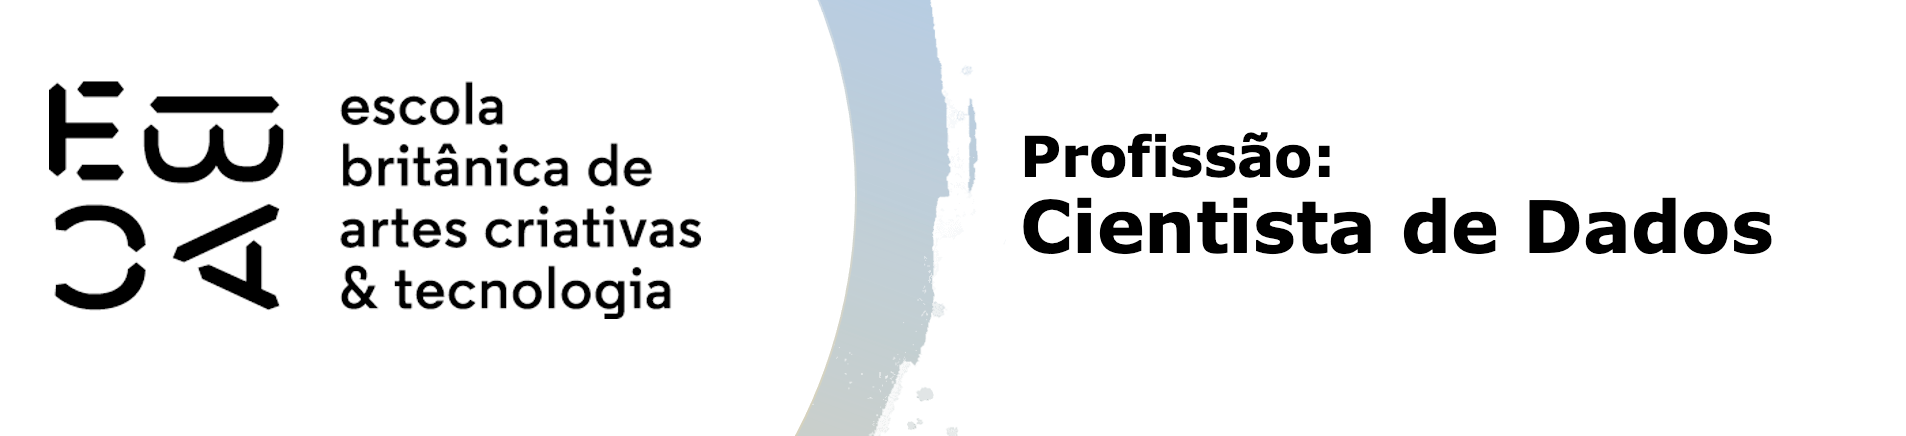

# Tarefa

Carregue a base ```NFP.ftr```. Essa base é proveniente do projeto #AMABiliDados, e contém dados da nota fiscal paulista cadastrados para doação automática para a AMA, Associação de Amigos do Autista. 

A *Nota Fiscal Paulista* é um programa de incentivo do governo do estado de São Paulo, que retorna um pedacinho do ICMS ao consumidor sempre que solicita o registro do seu CPF na nota. Nesse programa, o contribuinte pode direcionar seus créditos a uma ONG, e quando faz isso, sempre que faz esse consumidor cadastrado faz uma compra, os créditos de notas emitidas pelo mesmo estabelecimento não identificadas (notas sem CPF) são "arrastados" para a ONG na forma de uma doação.

Clique no link, caso queira saber mais sobre a [AMA](https://www.ama.org.br/site/).<br>
Clique no link, caso queira saber como o cidadão pode ser um [doador da NFP](https://doacao1.ama.org.br/sitenfp).

Essa base possui dados das notas cujos contribuintes direcionaram seus créditos à AMA. Seus campos estão descritos abaixo:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Análise da probabilidade de retorno

Considere somente os dados de janeiro de 2020 em diante para esta análise.

- Analise a proporção de notas que tiveram retorno>0 por categoria de estabelecimento. Esta análise pode ser por tabela ou gráfico.

C:\Users\samsun\AppData\Local\Temp\ipykernel_11772\2206417029.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020['retorno_positivo'] = df_2020['Retorno'] >0


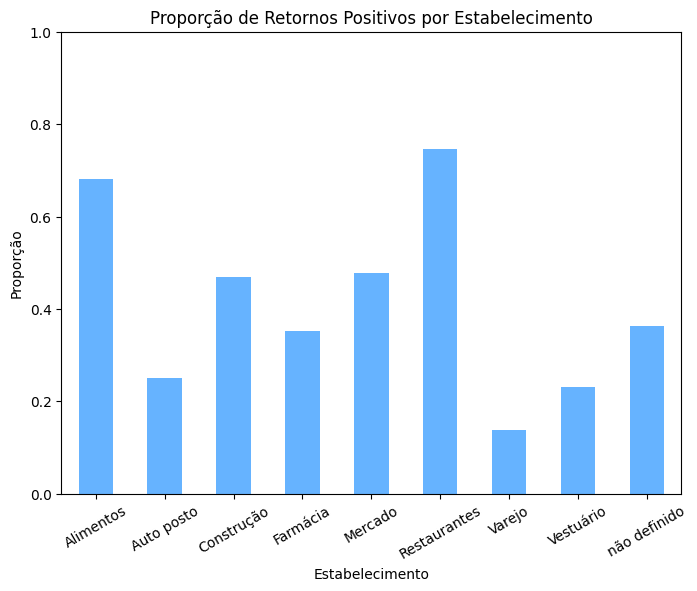

In [3]:
# Primeiramente iremos filtrar os dados de acordo com a data.
df_2020 = df.loc[df['Data Emissão'].dt.year >= 2020]

# Agora iremos calcular a proporção de retorno maior que 0 e agrupá-las por estabelecimanto.
df_2020['retorno_positivo'] = df_2020['Retorno'] >0
contagem_positivos = df_2020.groupby('categoria')['retorno_positivo'].sum()
contagem_total = df_2020.groupby('categoria')['retorno_positivo'].count()
proporcao_por_estabelecimento = contagem_positivos / contagem_total

# Plotando o gráfico de barras
proporcao_por_estabelecimento.plot(kind='bar', color='#66b3ff', figsize=(8, 6))
plt.title('Proporção de Retornos Positivos por Estabelecimento')
plt.ylabel('Proporção')
plt.xlabel('Estabelecimento')
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()

## Cálculo do WOE

- Calcule o WOE das categorias, sendo que o evento em questão é a nota ter retorno>0.
- Analise este WOE por tabela e por gráfico.

In [4]:
tab = pd.crosstab(df_2020['categoria'],df_2020['retorno_positivo'] , margins=True, margins_name='total')
tab['pct_nao_evento'] = tab[0] / tab.loc['total', 0]
tab['pct_evento'] = tab[1] / tab.loc['total', 1]
tab['RC'] = tab['pct_evento']/ tab['pct_nao_evento']
tab['WOE'] = np.log(tab['pct_evento']/tab['pct_nao_evento'])
tab

retorno_positivo,False,True,total,pct_nao_evento,pct_evento,RC,WOE
categoria,,,,,,,
Alimentos,1608,3442,5050,0.032395,0.092234,2.847218,1.046342
Auto posto,405,135,540,0.008159,0.003618,0.443379,-0.813331
Construção,8524,7523,16047,0.171723,0.201592,1.173934,0.160360
Farmácia,6607,3582,10189,0.133104,0.095986,0.721136,-0.326928
Mercado,14381,13177,27558,0.289718,0.353100,1.218775,0.197846
Restaurantes,553,1626,2179,0.011141,0.043571,3.911032,1.363801
Varejo,4365,701,5066,0.087937,0.018785,0.213614,-1.543585
Vestuário,1477,443,1920,0.029755,0.011871,0.398951,-0.918918
não definido,11718,6689,18407,0.236069,0.179243,0.759283,-0.275381


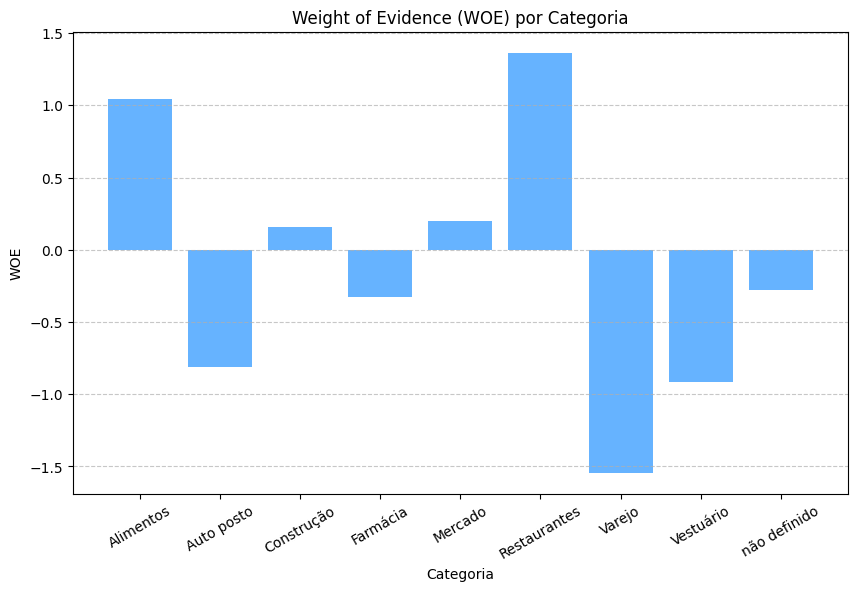

In [5]:
plt.figure(figsize=(10, 6))
plt.bar(tab.index[:-1], tab['WOE'][:-1], color='#66b3ff')
plt.title('Weight of Evidence (WOE) por Categoria')
plt.xlabel('Categoria')
plt.ylabel('WOE')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Cálculo do *Information Value*

Calcule o *IV* dessa variável.

In [6]:
tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.WOE
tab

retorno_positivo,False,True,total,pct_nao_evento,pct_evento,RC,WOE,iv_parcial
categoria,,,,,,,,
Alimentos,1608,3442,5050,0.032395,0.092234,2.847218,1.046342,0.062613
Auto posto,405,135,540,0.008159,0.003618,0.443379,-0.813331,0.003694
Construção,8524,7523,16047,0.171723,0.201592,1.173934,0.160360,0.004790
Farmácia,6607,3582,10189,0.133104,0.095986,0.721136,-0.326928,0.012135
Mercado,14381,13177,27558,0.289718,0.353100,1.218775,0.197846,0.012540
Restaurantes,553,1626,2179,0.011141,0.043571,3.911032,1.363801,0.044229
Varejo,4365,701,5066,0.087937,0.018785,0.213614,-1.543585,0.106742
Vestuário,1477,443,1920,0.029755,0.011871,0.398951,-0.918918,0.016434
não definido,11718,6689,18407,0.236069,0.179243,0.759283,-0.275381,0.015649


## <font color='blue'>**Conclusões**</font>

- Pelo que foi mostrado, vemos que os estabelecimentos com maior proporção de retornos positivos foram estabelecimentos do ramo de alimentos e restaurantes.
- Em valores absolutos, os maiores WOE são: <font color = 'red'>Restaurantes, Varejo e Alimentos</font>. Além destes, vestuário e auto postos, tambêm possuem valores significativos.
- Como é de se esperar, o Infomation Value confirma isso.

Por enquanto estes são os únicos insights, pois é apenas o que está no escopo do exercício, nas próximas análises poderemos inferir mais sobre essa base de dados.